run on Google Colab Pro

# Import packages

In [1]:
import os
import PIL
import torch
import requests
import numpy as np
from PIL import Image
import torch.nn.functional as F
import xml.etree.ElementTree as ET
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

# Download Pascal dataset

In [3]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2020-08-17 13:28:50--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  12.3MB/s    in 2m 37s  

2020-08-17 13:31:27 (12.2 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:
!mkdir datasets

In [5]:
!tar -C datasets/ -xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC2012/SegmentationClass/2008_002080.png
VOCdevkit/VOC

In [ ]:
!rm VOCtrainval_11-May-2012.tar

# Load images as tensors

In [2]:
def get_data(data_path):
    all_imgs = [] # it needs to be improved. Could raise a MemoryError

    classes_count = {}

    class_mapping = {}

    visualize = False

    print('Parsing annotation files\n')

    annot_path = os.path.join(data_path, 'Annotations')
    imgs_path = os.path.join(data_path, 'JPEGImages')
    trainval_files = []
    test_files = []

    # basically, what will be done next is to go through all lines,
    # in other words, go through each xml file
    annots = [os.path.join(annot_path, s) for s in os.listdir(annot_path)]
    i = 0
    for annot in annots:
        try:
            i += 1

            et = ET.parse(annot)
            element = et.getroot()
            element_objs = element.findall('object')
            element_filename = element.find('filename').text
            element_width = int(element.find('size').find('width').text)
            element_height = int(element.find('size').find('height').text)
            if len(element_objs) > 0:
                annotation_data = {
                    'filepath': os.path.join(imgs_path, element_filename),
                    'width': element_width,
                    'height': element_height,
                    'bboxes': []
                }
            
            for element_obj in element_objs:
                class_name = element_obj.find('name').text

                obj_bbox = element_obj.find('bndbox')
                x1 = int(round(float(obj_bbox.find('xmin').text)))
                y1 = int(round(float(obj_bbox.find('ymin').text)))
                x2 = int(round(float(obj_bbox.find('xmax').text)))
                y2 = int(round(float(obj_bbox.find('ymax').text)))
                difficulty = 1
                annotation_data['bboxes'].append(
                    {
                        'class': class_name,
                        'x1': x1,
                        'x2': x2,
                        'y1': y1,
                        'y2': y2,
                        'difficult': difficulty
                    }
                )
            all_imgs.append(annotation_data)

        except Exception as e:
            print(e)
            continue

    return all_imgs

In [7]:
all_imgs = get_data('/content/datasets/VOCdevkit/VOC2012')

Parsing annotation files



In [8]:
all_imgs[0]

{'bboxes': [{'class': 'person',
   'difficult': 1,
   'x1': 207,
   'x2': 272,
   'y1': 31,
   'y2': 219}],
 'filepath': '/content/datasets/VOCdevkit/VOC2012/JPEGImages/2012_000177.jpg',
 'height': 375,
 'width': 500}

In [9]:
len(all_imgs)

17125

In [10]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for img in all_imgs:

    image = Image.open(img.get("filepath"))
    torch_img = torch.from_numpy(np.array(image)).permute(2, 0, 1).unsqueeze(0).float().div(255)
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_torch_img = normalizer(torch_img)

    img.update({
        'tensors': [
            torch_img,
            normed_torch_img
        ]
    })

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/content/utils.py:204: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  return tensor.sub(mean).div(std)


In [11]:
vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda()

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

# Gradcam over all images

In [26]:
cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


In [ ]:
masks = dict()
for (gradcam, gradcam_pp), key in zip(cam_dict.values(), cam_dict.keys()):

    for img in all_imgs:

        mask, _ = gradcam(img.get("tensors")[1])
        mask_pp = gradcam_pp(img.get("tensors")[1])

        img.update({
            'masks': [
                mask,
                mask_pp
            ]
        })

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


# Preparing masks to vgg input

In [ ]:
input_masks = dict()

for key, tensors in masks.items():
    
    mask = cv2.cvtColor(np.uint8(255 * tensors[0].cpu().squeeze()), cv2.COLOR_GRAY2RGB)
    torch_img = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    
    mask_pp = cv2.cvtColor(np.uint8(255 * tensors[1].cpu().squeeze()), cv2.COLOR_GRAY2RGB)
    torch_img_pp = torch.tensor(mask_pp).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img_pp = F.upsample(torch_img_pp, size=(224, 224), mode='bilinear', align_corners=False)
    
    input_masks[key] = [
        torch_img,
        torch_img_pp
    ]

In [ ]:
F.softmax(pred).shape

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


torch.Size([1, 1000])

In [ ]:
predictions = dict()

for key, tensors in input_masks.items():
    
    mask_pred = F.softmax(vgg(tensors[0]))
    mask_pp_pred = F.softmax(vgg(tensors[1]))
    
    predictions[key] = [
        mask_pred[0, mask_pred.argmax(1)],
        mask_pp_pred[0, mask_pp_pred.argmax(1)]
    ]

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
predictions

{'collies': [tensor([0.1572], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.1997], device='cuda:0', grad_fn=<IndexBackward>)],
 'dogs': [tensor([0.0531], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0507], device='cuda:0', grad_fn=<IndexBackward>)],
 'snake': [tensor([0.1141], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0652], device='cuda:0', grad_fn=<IndexBackward>)],
 'bird': [tensor([0.0246], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0354], device='cuda:0', grad_fn=<IndexBackward>)]}

In [ ]:
# normal prediction

tensors = {}

normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for image, name in zip((collies_img, dogs_img, snake_img, bird_img), ('collies', 'dogs', 'snake', 'bird')):
    
    torch_img = torch.from_numpy(np.asarray(image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_torch_img = normalizer(torch_img)
    
    tensors.update({
        name: [
            normed_torch_img
        ]
    })

normal_predictions = dict()

for key, tensor in tensors.items():
    
    pred = F.softmax(vgg(tensor[0]))
    
    normal_predictions[key] = pred[0, pred.argmax(1)]

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
normal_predictions

{'collies': tensor([0.8405], device='cuda:0', grad_fn=<IndexBackward>),
 'dogs': tensor([0.3855], device='cuda:0', grad_fn=<IndexBackward>),
 'snake': tensor([0.5433], device='cuda:0', grad_fn=<IndexBackward>),
 'bird': tensor([1.0000], device='cuda:0', grad_fn=<IndexBackward>)}

# Metrics

## Average drop

In [ ]:
r = 0
r_pp = 0

for k in ('collies', 'dogs', 'snake', 'bird'):
    
    y = normal_predictions[k].cpu().data.numpy()[0]
    o = predictions[k][0].cpu().data.numpy()[0]
    o_pp = predictions[k][1].cpu().data.numpy()[0]
    
    r += _max(y - o) / y
    r_pp += _max(y - o_pp) / y

In [ ]:
print("Average drop for Grad-CAM: {}".format(r))
print("Average drop for Grad-CAM++: {}".format(r_pp))

Average drop for Grad-CAM: 3.440488636493683
Average drop for Grad-CAM++: 3.475645661354065


## Increase in confidence

In [ ]:
diff = dict()

for k in ('collies', 'dogs', 'snake', 'bird'):
    
    y = normal_predictions[k].cpu().data.numpy()[0]
    o = predictions[k][0].cpu().data.numpy()[0]
    o_pp = predictions[k][1].cpu().data.numpy()[0]
    
    r = y - o
    r_pp = y - o_pp
    
    diff[k] = (
        1 if r < 0 else 0,
        1 if r_pp < 0 else 0
    )

In [ ]:
diff

{'collies': (0, 0), 'dogs': (0, 0), 'snake': (0, 0), 'bird': (0, 0)}

In [ ]:
# all zero :/

## Intersection over Union

In [115]:
def get_new_img_size(width, height, img_min_side=224):
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side

    return resized_width, resized_height

### make masks over class c

#### c = 'aeroplane'

In [20]:
aeroplane = list()

for img in all_imgs:

    for bbox in img.get("bboxes"):

        if bbox.get("class") == 'aeroplane':

            aeroplane.append(img)

            break

In [28]:
cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

masks = dict()
for (gradcam, gradcam_pp), key in zip(cam_dict.values(), cam_dict.keys()):

    for img in aeroplane:

        mask, _ = gradcam(img.get("tensors")[1].cuda())
        mask_pp, _ = gradcam_pp(img.get("tensors")[1].cuda())

        img.update({
            'masks': [
                mask,
                mask_pp
            ]
        })

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [88]:
for img in aeroplane:

    I = img.get("tensors")[0].squeeze().permute(1, 2, 0).data.numpy()
    L = ((img.get("masks")[0] - torch.min(img.get("masks")[0])) / torch.max(img.get("masks")[0]))[0].permute(1, 2, 0).cpu().data.numpy()
    L_pp = ((img.get("masks")[1] - torch.min(img.get("masks")[1])) / torch.max(img.get("masks")[1]))[0].permute(1, 2, 0).cpu().data.numpy()

    E = np.multiply(L, I)
    E_pp = np.multiply(L_pp, I)

    img.update({
        'E': [
            E,
            E_pp
        ]
    })

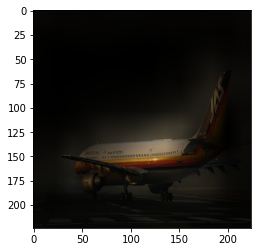

In [119]:
import matplotlib.pyplot as plt
plt.imshow(aeroplane[0]["E"][1])

In [121]:
bbox_total_area = 0
total_internal_area = 0
total_external_area = 0
total_internal_area_pp = 0
total_external_area_pp = 0

for img in aeroplane:

    width, height = (img['width'], img['height'])
    resized_width, resized_height = get_new_img_size(width, height)

    # get bboxes which class is c according to paper
    bboxes = list(filter(
        lambda item: item.get("class") == "aeroplane",
        img.get("bboxes")
    ))

    instant_internal_area = 0
    instant_internal_area_pp = 0
    instant_external_area = 0
    instant_external_area_pp = 0

    E = img.get("E")[0]
    E_pp = img.get("E")[1]

    for bbox in bboxes:

        bbox.update({
            'x1': bbox.get("x1") * int(round(width/resized_width)),
            'x2': bbox.get("x2") * int(round(width/resized_width)),
            'y1': bbox.get("y1") * int(round(height, resized_height)),
            'y2': bbox.get("y2") * int(round(height, resized_height))
        })

        bbox_total_area += (bbox.get("x1") + bbox.get("x2")) * (bbox.get("y1") + bbox.get("y2"))

        _E = E[bbox.get("y1"):bbox.get("y2"), bbox.get("x1"):bbox.get("x2"), :]
        _E_pp = E_pp[bbox.get("y1"):bbox.get("y2"), bbox.get("x1"):bbox.get("x2"), :]

        # go through each pixel and check whether it is greater than zero
        for i in range(_E.shape[0]):
            for j in range(_E.shape[1]):
                for k in range(_E.shape[2]):

                    if np.greater(_E[i, j, k], 0):
                        instant_internal_area += 1

        for i in range(_E_pp.shape[0]):
            for j in range(_E_pp.shape[1]):
                for k in range(_E_pp.shape[2]):

                    if np.greater(_E_pp[i, j, k], 0):
                        instant_internal_area_pp += 1

    # go through every pixel on image and check whether it is greater than zero
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            for k in range(E.shape[2]):

                if np.greater(E[i, j, k], 0):
                    instant_external_area += 1

    for i in range(E_pp.shape[0]):
        for j in range(E_pp.shape[1]):
            for k in range(E_pp.shape[2]):

                if np.greater(E_pp[i, j, k], 0):
                    instant_external_area += 1

    total_internal_area += instant_internal_area
    total_internal_area_pp += instant_internal_area_pp

    total_external_area += (instant_external_area - instant_internal_area)
    total_external_area_pp += (instant_external_area_pp - instant_internal_area_pp)

In [122]:
print("Loc(0) for Grad-CAM: {}".format(
    total_internal_area / (bbox_total_area + total_external_area)
))
print("Loc(0) for Grad-CAM++: {}".format(
    total_internal_area_pp / (bbox_total_area + total_external_area_pp)
))

Loc(0) for Grad-CAM: 0.0
Loc(0) for Grad-CAM++: 0.0


#### c = 'person'

In [12]:
person = list()

for img in all_imgs:

    for bbox in img.get("bboxes"):

        if bbox.get("class") == 'person':

            person.append(img)

            break

In [ ]:
cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

masks = dict()
for (gradcam, gradcam_pp), key in zip(cam_dict.values(), cam_dict.keys()):

    for img in person:

        mask, _ = gradcam(img.get("tensors")[1].cuda())
        mask_pp = gradcam_pp(img.get("tensors")[1].cuda())

        img.update({
            'masks': [
                mask,
                mask_pp
            ]
        })

In [ ]:
loc = 0

for img in all_imgs:

    I = img.get("tensors")[0].data.numpy()
    L = ((img.get("masks")[0] - torch.min(img.get("masks")[0])) / torch.max(img.get("masks")[0])).data.numpy()
    L_pp = ((img.get("masks")[1] - torch.min(img.get("masks")[1])) / torch.max(img.get("masks")[1])).data.numpy()

    E = np.multiply(L, I)
    E_pp = np.multiply(L_pp, I)

    for bbox in img.get("bboxes"):

        if bbox.get("class") == 'person':

            bbox_area = (bbox.get("x1") + bbox.get("x2")) * (bbox.get("y1") + bbox.get("y2"))